# CS 189 Neural Networks Homework
**Note:** before starting this notebook, please save a copy of it to your own google drive, or your changes will not persist.

This part of the assignment is designed to get you familiar with how engineers in the real world train neural network systems. It isn't designed to be difficult. In fact, everything you need to complete the assignment is available directly on the pytorch website [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html). This note book will have the following components:

1. Understanding the basics of Pytorch (no deliverables)
2. Training a simple neural network on FasionMNIST (Deliverable = training graphs)
3. Training a convolutional neural network on CIFAR-10 (Deliverable = training graphs, explanation of methods and CSV file)

You will also get practice being an ML engineer, by reading documentation and using it to implement models. The first section of this notebook will cover an outline of what you need to know -- we are confident that you can find the rest on your own.

You just need to complete the deliverables and turn in your code. If you want to run this notebook locally on your own GPUs, make sure to appropriately install pytorch on your system. If you don't want to use pytorch and instead want to experiment with Tensorflow, feel free, but you may still need to install pytorch to download the datasets. Moreover, our staff has more familiarity with pytorch, and may be unable to assist you in case you run into any errors with tensorflow.


In [1]:
# Imports for pytorch
import numpy as np
import torch
import torchvision
from torch import nn
import matplotlib
from matplotlib import pyplot as plt
import tqdm.notebook as tqdm

# 1. Understanding Pytorch

Pytorch is based on the "autograd" paradigm. Essentially, you perform operations on multi-dimensional arrays like in numpy, except pytorch will automatically handle gradient tracking. In this section you will understand how to use pytorch.

This section should help you understand the full pipeline of creating and training a model in pytorch. Feel free to re-use code from this section in the assigned tasks.

Content in this section closely follows this pytorch tutorial: https://pytorch.org/tutorials/beginner/basics/intro.html

## Tensors

Tensors can be created from numpy data or by using pytorch directly.

In [2]:
data = [[1, 2], [3, 4]]
x_data = torch.tensor(data)

np_array = np.array(data)
x_np = torch.from_numpy(np_array)

shape = (2,3,)
rand_tensor = torch.rand(shape)
np_rand_array = rand_tensor.numpy()

print(f"Tensor from np: \n {x_np} \n")
print(f"Rand Tensor: \n {rand_tensor} \n")
print(f"Rand Numpy Array: \n {np_rand_array} \n")

Tensor from np: 
 tensor([[1, 2],
        [3, 4]]) 

Rand Tensor: 
 tensor([[0.5278, 0.3877, 0.7947],
        [0.5390, 0.3848, 0.6211]]) 

Rand Numpy Array: 
 [[0.5278085  0.3876655  0.7946746 ]
 [0.53903896 0.38478714 0.6211191 ]] 



They also support slicing and math operations very similar to numpy. See the examples below:

In [3]:
# Slicing
tensor = torch.ones(4, 4)
print('First row: ',tensor[0])
print('First column: ', tensor[:, 0])

# Matrix Operations
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

# Getting a single item
scalar = torch.sum(y1) # sums all elements
item = scalar.item()
print("Sum as a tensor:", scalar, ", Sum as an item:", item)

First row:  tensor([1., 1., 1., 1.])
First column:  tensor([1., 1., 1., 1.])
Sum as a tensor: tensor(64.) , Sum as an item: 64.0


## Autograd
This small section shows you how pytorch computes gradients. When we create tenors, we can set `requires_grad` to be true to indicate that we are using gradients. For most of the work that you actually do, you will use the `nn` package, which automatically sets all parameter tensors to have `requires_grad=True`.

In [4]:
# Below is an example of computing the gradient for a single data point in logistic regression using pytorch's autograd.

x = torch.ones(5)  # input tensor
y = torch.zeros(1) # label
w = torch.randn(5, 1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
pred = torch.sigmoid(torch.matmul(x, w) + b)
loss = torch.nn.functional.binary_cross_entropy(pred, y)
loss.backward() # Computers gradients
print("W gradient:", w.grad)
print("b gradient:", b.grad)

# when we want to actually take an update step, we can use optimizers:
optimizer = torch.optim.SGD([w, b], lr=0.1)
print("Weight before", w)
optimizer.step() # use the computed gradients to update
# Print updated weights
print("Updated weight", w)

# Performing operations with gradients enabled is slow...
# You can disable gradient computation using the following enclosure:
with torch.no_grad():
    # Perform operations without gradients
    ...

W gradient: tensor([[0.3785],
        [0.3785],
        [0.3785],
        [0.3785],
        [0.3785]])
b gradient: tensor([0.3785])
Weight before tensor([[-0.4394],
        [-0.5183],
        [-0.5409],
        [-0.3552],
        [ 0.3562]], requires_grad=True)
Updated weight tensor([[-0.4773],
        [-0.5561],
        [-0.5788],
        [-0.3931],
        [ 0.3183]], requires_grad=True)


## Devices
Pytorch supports accelerating computation using GPUs which are available on google colab. To use a GPU on google colab, go to runtime -> change runtime type -> select GPU.

Note that there is some level of strategy for knowing when to use which runtime type. Colab will kick users off of GPU for a certain period of time if you use it too much. Thus, its best to run simple models and prototype to get everything working on CPU, then switch the instance type over to GPU for training runs and parameter tuning.

Its best practice to make sure your code works on any device (GPU or CPU) for pytorch, but note that numpy operations can only run on the CPU. Here is a standard flow for using GPU acceleration:

In [5]:
# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# Next create your tensors
tensor = torch.zeros(4, 4, requires_grad=True)
# Move the tensor to the device you want to use
tensor = tensor.to(device)

# Perform whatever operations you want.... (often this will involve gradients)
# These operations will be accelerated by GPU.
tensor = 10*(tensor + 1)

# bring the tensor back to CPU, first detaching it from any gradient computations
tensor = tensor.detach().cpu()

tensor_np = tensor.numpy() # Convert to numpy if you want to perform numpy operations.

Using device cpu


## The NN Package
Pytorch implements composable blocks in `Module` classes. All layers and modules in pytorch inherit from `nn.Module`. When you make a module you need to implement two functions: `__init__(self, *args, **kwargs)` and `forward(self, *args, **kwargs)`. Modules also have some nice helper functions, namely `parameters` which will recursively return all of the parameters. Here is an example of a logistic regression model:

In [6]:
class Perceptron(nn.Module):
  def __init__(self, in_dim):
    super().__init__()
    self.layer = nn.Linear(in_dim, 1) # This is a linear layer, it computes Xw + b

  def forward(self, x):
    return torch.sigmoid(self.layer(x)).squeeze(-1)

perceptron = Perceptron(10)
perceptron = perceptron.to(device) # Move all the perceptron's tensors to the device
print("Parameters", list(perceptron.parameters()))

Parameters [Parameter containing:
tensor([[-0.2139, -0.2367, -0.2422, -0.2075,  0.2425, -0.0813, -0.1473,  0.0826,
          0.2489, -0.0230]], requires_grad=True), Parameter containing:
tensor([0.0273], requires_grad=True)]


## Datasets

Pytorch has nice interfaces for using datasets. Suppose we create a logistic regression dataset as follows:

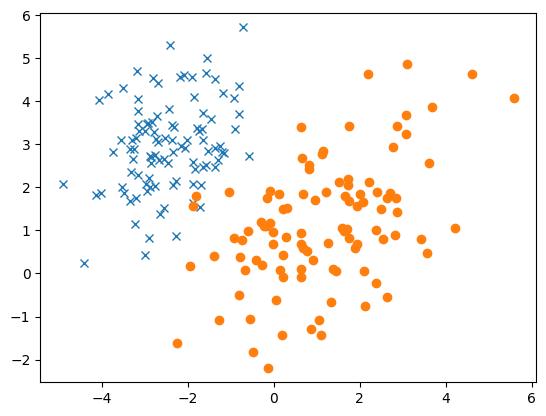

In [7]:
c1_x1, c1_x2 = np.random.multivariate_normal([-2.5,3], [[1, 0.3],[0.3, 1]], 100).T
c2_x1, c2_x2 = np.random.multivariate_normal([1,1], [[2, 1],[1, 2]], 100).T
c1_X = np.vstack((c1_x1, c1_x2)).T
c2_X = np.vstack((c2_x1, c2_x2)).T
train_X = np.concatenate((c1_X, c2_X))
train_y = np.concatenate((np.zeros(100), np.ones(100)))
# Shuffle the data
permutation = np.random.permutation(train_X.shape[0])
train_X = train_X[permutation, :]
train_y = train_y[permutation]
# Plot the data
plt.plot(c1_x1, c1_x2, 'x')
plt.plot(c2_x1, c2_x2, 'o')
plt.axis('equal')
plt.show()

We can then create a pytorch dataset object as follows. Often times, the default pytorch datasets will create these objects for you. Then, we can apply dataloaders to iterate over the dataset in batches.

In [8]:
dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
# We can create a dataloader that iterates over the dataset in batches.
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
for x, y in dataloader:
    print("Batch x:", x)
    print("Batch y:", y)
    break

# Clean up the dataloader as we make a new one later
del dataloader

Batch x: tensor([[ 1.1494,  2.8492],
        [ 1.5118,  2.1372],
        [-2.3408,  2.8214],
        [-1.7067,  1.5376],
        [-2.5244,  3.1494],
        [-1.6523,  2.4647],
        [-0.6658,  0.0745],
        [ 0.2139,  0.4222],
        [-0.9295,  0.8196],
        [-3.3366,  2.8940]], dtype=torch.float64)
Batch y: tensor([1., 1., 0., 0., 0., 0., 1., 1., 1., 0.], dtype=torch.float64)


## Training Loop Example
Here is an example of training a full logistic regression model in pytorch. Note the extensive use of modules -- modules can be used for storing networks, computation steps etc.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

epochs = 10
batch_size = 10
learning_rate = 0.01

num_features = dataset[0][0].shape[0]
model = Perceptron(num_features).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCELoss()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model.train() # Put model in training mode
for epoch in range(epochs):
    training_losses = []
    for x, y in tqdm.tqdm(dataloader, unit="batch"):
        x, y = x.float().to(device), y.float().to(device)
        optimizer.zero_grad() # Remove the gradients from the previous step
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
    print("Finished Epoch", epoch + 1, ", training loss:", np.mean(training_losses))

# We can run predictions on the data to determine the final accuracy.
with torch.no_grad():
    model.eval() # Put model in eval mode
    num_correct = 0
    for x, y in dataloader:
        x, y = x.float().to(device), y.float().to(device)
        pred = model(x)
        num_correct += torch.sum(torch.round(pred) == y).item()
    print("Final Accuracy:", num_correct / len(dataset))
    model.train() # Put model back in train mode

Using device cpu


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 1 , training loss: 1.9164264380931855


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 2 , training loss: 1.2296222746372223


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 3 , training loss: 0.761646369099617


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 4 , training loss: 0.5284210175275803


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 5 , training loss: 0.42213198244571687


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 6 , training loss: 0.3672754541039467


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 7 , training loss: 0.33476770892739294


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 8 , training loss: 0.3130157619714737


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 9 , training loss: 0.2970937617123127


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 10 , training loss: 0.28488546684384347
Final Accuracy: 0.93


# Task 1: MLP For FashionMNIST
Now you will train a multi-layer perceptron model on the FashionMNIST dataset. Your deliverables are as follows:

1. Code for training an MLP on FashionMNIST.
2. A plot of the training and validation loss for at least 8 epochs.
3. A plot of the training and validation accuracy for each epoch, achieving a final validation accuracy of at least 82% by the end of the training.

Below we will create the training and validation datasets for you. It is on you to implement an MLP / Feed Forward neural network yourself. Please leverage the example training loop from above.

Here are some pytorch components that you should definitely use:
1. `nn.Linear`
2. Some activation: `nn.ReLU`, `nn.Tanh`, `nn.Sigmoid`, etc.
3. `nn.CrossEntropyLoss`

Here are some challenges that you will need to overcome:
1. The data is, by default, configured in image form, i.e. a (28 x 28) tensor per sample, instead of single feature vector. You will need to reshape it somewhere to feed it in as vector to the MLP. There are many ways of doing this.
2. You need to write code for plotting.
3. You need to find the appropriate hyper-parameters to achieve good accuracy.

Your underlying model must be fully connected or "dense", and may not use any convolutions etc., but you can use anything in `torch.optim` or any layers in `torch.nn` besides `nn.Linear` that do not have weights.

In [10]:
# Creating the datasets
transform = torchvision.transforms.ToTensor() # feel free to modify this as you see fit.

training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

validation_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

100%|██████████| 26421880/26421880 [00:01<00:00, 16515349.45it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 342855.63it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6002350.15it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21700780.90it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Before training a neural network, let's visualize our data first! Running the cell below will display the first 9 images in a 3 by 3 grid.

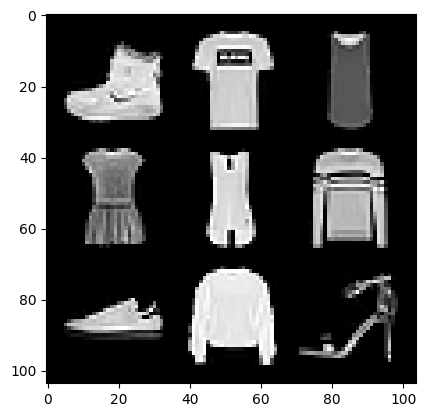

In [11]:
images = [training_data[i][0] for i in range(9)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=3, padding=5).numpy().transpose((1, 2, 0)))

In [12]:
class MultiLayerPerceptron(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.ReLU()
        )


  def forward(self, x):
    return self.layers(x)

In [13]:
def count_correct(model_output, y):
  predictions = torch.argmax(model_output, dim=1)
  return torch.sum(torch.eq(predictions, y)).item()

def train(model, data_loader):
  model.train()
  losses = []
  num_correct = 0
  for x_raw, y in tqdm.tqdm(data_loader, unit="batch"):
      x = torch.reshape(x_raw, (x_raw.shape[0], -1))
      optimizer.zero_grad() # Remove the gradients from the previous step
      pred = model(x)
      loss = criterion(pred, y)
      loss.backward()
      optimizer.step()
      losses.append(loss.item())
      num_correct += count_correct(pred, y)
  return np.mean(losses), num_correct/len(data_loader.dataset)

def validate(model, data_loader):
  with torch.no_grad():
    model.eval()
    losses = []
    num_correct = 0
    for x_raw, y in tqdm.tqdm(data_loader, unit="batch"):
      x = torch.reshape(x_raw, (x_raw.shape[0], -1))
      pred = model(x)
      loss = criterion(pred, y)
      losses.append(loss.item())
      num_correct += count_correct(pred, y)
    return np.mean(losses), num_correct/len(data_loader.dataset)

In [14]:
### YOUR CODE HERE ###
skip = True
if not skip:
  model = MultiLayerPerceptron()

  epochs = 10
  batch_size = 10
  learning_rate = 0.1

  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  criterion = torch.nn.CrossEntropyLoss()

  train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
  validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=False)
  model.train() # Put model in training mode
  train_losses = []
  train_accuracies = []
  validation_losses = []
  validation_accuracies = []
  for epoch in range(epochs):
      # Train and add metrics
      train_loss, train_accuracy = train(model, train_loader)
      print(train_loss, train_accuracy)
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)

      # Validate and add metrics
      validation_loss, validation_accuracy = validate(model, validation_loader)
      print(validation_loss, validation_accuracy)
      validation_losses.append(validation_loss)
      validation_accuracies.append(validation_accuracy)


In [15]:
import matplotlib.pyplot as plt
if not skip:
  plt.plot(range(epochs), train_losses, label='Training loss')
  plt.plot(range(epochs), validation_losses, label='Validation loss')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and validation loss')
  plt.show()

  plt.plot(range(epochs), train_accuracies, label='Training accuracy')
  plt.plot(range(epochs), validation_accuracies, label='Validation accuracy')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training and validation accuracy')
  plt.show()

  print(f"Final validation accuracy: {validation_accuracies[-1]}")

# Task 2: CNNs for CIFAR-10

In this section, you will create a CNN for the CIFAR dataset, and submit your predictions to the autograder. It is recommended that you use GPU acceleration for this part.

Here are some of the components you should consider using:
1. `nn.Conv2d`
2. `nn.ReLU`
3. `nn.Linear`
4. `nn.CrossEntropyLoss`
5. `nn.MaxPooling2d` (though many implementations without it exist)

We encourage you to explore different ways of improving your model to obtain higher accuracies. Here are some suggestions for things to look into:
1. Popular CNN architectures like ResNets, etc.
2. Different optimizers and their parameters (see `torch.optim`)
3. Image preprocessing / data augmentation (see `torchvision.transforms`)
4. Regularization or dropout (see `torch.optim` and `torch.nn` respectively)
5. Learning rate scheduling: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
6. Weight initialization: https://pytorch.org/docs/stable/nn.init.html

Though we encourage you to explore, there are some rules:
1. You are not allowed to install or use packages not included by default in the Colab Environment.
2. You are not allowed to use any pre-defined architectures or feature extractors in your network.
3. You are not allowed to use **any** pretrained weights, i.e. no transfer learning.
4. You cannot train on the test data (that would pretty much defeat the whole point of machine learning).

Otherwise everything is fair game!

Your deliverables are as follows:
1. Code for training a CNN on CIFAR-10.
2. Provide at least (1) training curve for your model, depicting loss per epoch or step after training for at least 8 epochs.
3. Explain the components of your final model, and how you think your design choices contributed to it's performance.

After you train your model, we have included skeleton code that should be used to generate the predictions that will be submitted to the Autograder. **You must follow the instructions below under the submission header**. Note that if you apply any processing or transformations to the data, you will need to do the same to the test data, otherwise you will likely achieve very low accuracy.

It is expected that this task will take a while to train. Our very simple solution achieves a training accuracy of 90.2% and a test accuracy of 74.8% after 10 epochs (be careful of overfitting!). That said, it is possible to achieve 95% or higher test accuracy on CIFAR 10 with a good model design and some hyperparameter tuning. For this assignment, your model should achieve an accuracy above 80%.

In [16]:
# Creating the datasets, feel free to change this as long as you do the same to the test data.
# You can also modify this to split the data into training and validation.
# See https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split
import torchvision.transforms as transforms
transform = train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

data = torchvision.datasets.CIFAR10(
    root="data",
    download=True,
    transform=transform,
)
n = len(data)
n_train = int(0.8 * n)
n_validation = n - n_train
training_data, validation_data = torch.utils.data.random_split(data, [n_train, n_validation])
# If you make a train-test partition it is up to you.

100%|██████████| 170498071/170498071 [00:02<00:00, 77270854.55it/s]


Extracting data/cifar-10-python.tar.gz to data


Again, let's first visualize our data.

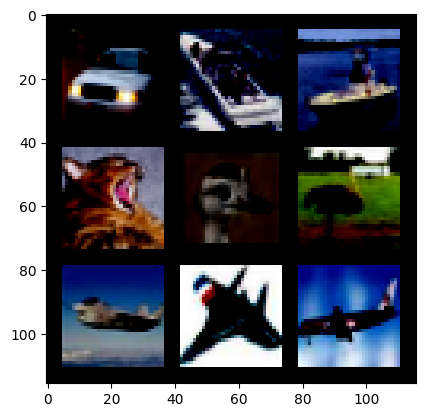

In [17]:
images = [training_data[i][0] for i in range(9)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=3, padding=5).numpy().transpose((1, 2, 0)))

In [18]:
class CNN(nn.Module):
  def __init__(self, out_dim):
    super().__init__()
    self.convolutions = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

    self.classifier = nn.Sequential(
            nn.Flatten(1),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(64 * 2 * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

  def forward(self, x):
    x = self.convolutions(x)
    x = self.classifier(x)
    return x


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cpu


In [20]:
def train(model, data_loader):
  model.train()
  losses = []
  num_correct = 0
  for x, y in tqdm.tqdm(data_loader, unit="batch"):
      optimizer.zero_grad() # Remove the gradients from the previous step
      x, y = x.to(device), y.to(device)
      pred = model(x)
      loss = criterion(pred, y)
      loss.backward()
      optimizer.step()
      losses.append(loss.item())
      num_correct += count_correct(pred, y)
  return np.mean(losses), num_correct/len(data_loader.dataset)

def validate(model, data_loader):
  with torch.no_grad():
    model.eval()
    losses = []
    num_correct = 0
    for x, y in tqdm.tqdm(data_loader, unit="batch"):
      x, y = x.to(device), y.to(device)
      pred = model(x)
      loss = criterion(pred, y)
      losses.append(loss.item())
      num_correct += count_correct(pred, y)
    return np.mean(losses), num_correct/len(data_loader.dataset)

In [21]:
epochs = 10
batch_size = 20
learning_rate = 0.01

training_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=False)
model = CNN(10).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []
for epoch in range(epochs):
    print(f"\nEpoch: {epoch}")
    # Train and add metrics
    training_loss, training_accuracy = train(model, training_loader)
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)
    print(f"Training loss: {training_loss}\nTraining accuracy: {training_accuracy}")

    # Validate and add metrics
    validation_loss, validation_accuracy = validate(model, validation_loader)
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)
    print(f"Validation loss: {validation_loss}\nValidation accuracy: {validation_accuracy}")


Epoch: 0


  0%|          | 0/2000 [00:00<?, ?batch/s]

Training loss: 1.6566830388903617
Training accuracy: 0.3826


  0%|          | 0/500 [00:00<?, ?batch/s]

Validation loss: 1.3556907460689545
Validation accuracy: 0.4904

Epoch: 1


  0%|          | 0/2000 [00:00<?, ?batch/s]

Training loss: 1.2568290221989156
Training accuracy: 0.542675


  0%|          | 0/500 [00:00<?, ?batch/s]

Validation loss: 1.1307115803956986
Validation accuracy: 0.585

Epoch: 2


  0%|          | 0/2000 [00:00<?, ?batch/s]

Training loss: 1.097688699066639
Training accuracy: 0.602175


  0%|          | 0/500 [00:00<?, ?batch/s]

Validation loss: 0.9976887732148171
Validation accuracy: 0.6377

Epoch: 3


  0%|          | 0/2000 [00:00<?, ?batch/s]

Training loss: 0.9973575665801764
Training accuracy: 0.64375


  0%|          | 0/500 [00:00<?, ?batch/s]

Validation loss: 0.9556572614908219
Validation accuracy: 0.6626

Epoch: 4


  0%|          | 0/2000 [00:00<?, ?batch/s]

Training loss: 0.9284341716468334
Training accuracy: 0.668975


  0%|          | 0/500 [00:00<?, ?batch/s]

Validation loss: 0.9184019436240196
Validation accuracy: 0.674

Epoch: 5


  0%|          | 0/2000 [00:00<?, ?batch/s]

Training loss: 0.8720836450755596
Training accuracy: 0.692525


  0%|          | 0/500 [00:00<?, ?batch/s]

Validation loss: 0.8608821068704128
Validation accuracy: 0.7002

Epoch: 6


  0%|          | 0/2000 [00:00<?, ?batch/s]

Training loss: 0.8336254596412181
Training accuracy: 0.704275


  0%|          | 0/500 [00:00<?, ?batch/s]

Validation loss: 1.007443893313408
Validation accuracy: 0.6416

Epoch: 7


  0%|          | 0/2000 [00:00<?, ?batch/s]

Training loss: 0.7919953722208738
Training accuracy: 0.7198


  0%|          | 0/500 [00:00<?, ?batch/s]

Validation loss: 0.8614609820842742
Validation accuracy: 0.6971

Epoch: 8


  0%|          | 0/2000 [00:00<?, ?batch/s]

Training loss: 0.7666433218494058
Training accuracy: 0.73005


  0%|          | 0/500 [00:00<?, ?batch/s]

Validation loss: 0.8230956183671951
Validation accuracy: 0.7125

Epoch: 9


  0%|          | 0/2000 [00:00<?, ?batch/s]

Training loss: 0.7342068638280034
Training accuracy: 0.740075


  0%|          | 0/500 [00:00<?, ?batch/s]

Validation loss: 0.8137902167141438
Validation accuracy: 0.7141


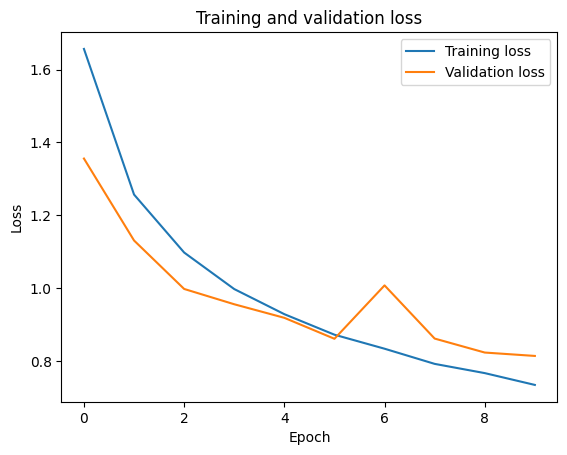

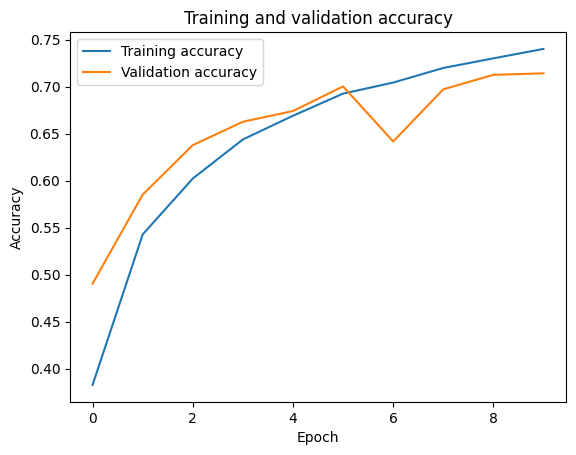

Final validation accuracy: 0.7141


In [22]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), training_losses, label='Training loss')
plt.plot(range(epochs), validation_losses, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.show()

plt.plot(range(epochs), training_accuracies, label='Training accuracy')
plt.plot(range(epochs), validation_accuracies, label='Validation accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.show()

print(f"Final validation accuracy: {validation_accuracies[-1]}")

### Autograder Submission
The following code is for you to make your submission to the gradescope autograder. Here are the steps you must follow:

1. Upload `cifar10_test_data_fa23.npy` to the colab notebook by going to files on the right hand pane, then hitting "upload".
2. Run the following cell to generate the dataset object for the test data. Feel free to modify the code to use the same transforms that you use for the training data. By default, this will re-use the `transform` variable.
3. In the second cell, write code to run predictions on the testing dataset and store them into an array called `predictions`.
4. Run the final cell which will convert your predictions array into a CSV file.
5. Go to the files pane again, and download the file called `submission.csv` by clicking the three dots and then download.


In [27]:
from PIL import Image
import os

class CIFAR10Test(torchvision.datasets.VisionDataset):

    def __init__(self, transform=None, target_transform=None):
        super(CIFAR10Test, self).__init__(None, transform=transform,
                                      target_transform=target_transform)
        assert os.path.exists("cifar10_test_data_fa23.npy"), "You must upload the test data to the file system."
        self.data = [np.load("cifar10_test_data_fa23.npy", allow_pickle=False)]

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index: int):
        img = self.data[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self) -> int:
        return len(self.data)
transform = train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
# Create the test dataset
testing_data = CIFAR10Test(
    transform=transform, # NOTE: Make sure transform is the same as the one used in the training dataset.
)

In [32]:
### YOUR CODE HERE ###
def predict(model, data_loader):
  predictions = []
  with torch.no_grad():
    model.eval()
    for x in tqdm.tqdm(data_loader, unit="batch"):
      x= x.to(device)
      pred = model(x)
      predictions.extend(torch.argmax(pred, dim=1).tolist())
    return predictions
# Recommendation: create a `test_dataloader` from torch.utils.data.DataLoader with `shuffle=False` to iterate over the test data in batches.
test_dataloader = torch.utils.data.DataLoader(testing_data, batch_size=10, shuffle=False)
# Store a numpy vector of the predictions for the test set in the variable `predictions`.
predictions = predict(model, test_dataloader)


  0%|          | 0/1000 [00:00<?, ?batch/s]

In [33]:
# This code below will generate the predictions.csv file.
import pandas as pd

if isinstance(predictions, np.ndarray):
    predictions = predictions.astype(int)
else:
    predictions = np.array(predictions, dtype=int)
assert predictions.shape == (len(testing_data),), "Predictions were not the correct shape"
df = pd.DataFrame({'Category': predictions})
df.index += 1  # Ensures that the index starts at 1.
df.to_csv('predictions.csv', index_label='Id')

# Now download the predictions.csv file to submit.

Congrats! You made it to the end.